In [1]:
# generate heatmap of opening moves which leads to a loss/win/draw

In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def getMoves(board):
    moves = []
    for i in range(len(board)):
        for j in range(len(board[i])):
            if board[i][j] == 0:
                moves.append((i, j))
    return moves

def check_win(arr):
    
    if len(arr) == 3:
    
        if arr[0] == arr[1] == arr[2] == 1:
            return 1
        elif arr[0] == arr[1] == arr[2] == 2:
            return 2
        else:
            return False
        
    elif len(arr) == 4:

        if arr[0] == arr[1] == arr[2] == arr[3] == 1:
            return 1
        elif arr[0] == arr[1] == arr[2] == arr[3] == 2:
            return 2
        else:
            return False

    elif len(arr) == 5:
        
        if arr[0] == arr[1] == arr[2] == arr[3] == 1:
            return 1
        elif arr[1] == arr[2] == arr[3] == arr[4] == 1:
            return 1
        elif arr[0] == arr[1] == arr[2] == arr[3] == 2:
            return 2
        elif arr[1] == arr[2] == arr[3] == arr[4] == 2:
            return 2
        else:
            return False
        
def getWinner(board):
    # represent the board as an array for easier manipulation
    board_array = np.array(board)
    wins = []
    
    n = len(board)
    
    
    # iterate through columns to check for vertical wins
    for j in range(n):
        # slice each column, check for win
        winner = check_win(board_array[:, j])
        wins.append(winner)

    # iterate through rows to check for horizontal wins
    for i in range(n):
        # slice each row, check for win
        winner = check_win(board_array[i, :])
        wins.append(winner)

    # get diagonals of board
    # note: this approach identifies ALL diagonals in the board (not only those of length 3), handled later
    diags = [board_array[::-1, :].diagonal(i) for i in range(-board_array.shape[0] + 1, board_array.shape[1])]
    diags.extend(board_array.diagonal(i) for i in range(board_array.shape[1] - 1, -board_array.shape[0], -1))

    # only the main diagonal and anti diagonal can be used for a win, so check for win only in those
    for each in diags:
        if len(each) == 3:
            wins.append(check_win(each))
        else:
            if len(each) >= 4:
                wins.append(check_win(each))

    # remove all booleans, leaving only integer values (1 or 2) to indicate a winner
    wins2 = [win for win in wins if win]

    # if there is no integer in wins2 (no winner yet) and if there are no more valid moves, it's a tie (return 0)
    if not wins2:
        if len(getMoves(board)) == 0:
            return 0

    # if there is an integer in wins2, there is a winner. return the winner, else, there are still moves to be made (return -1)
    if wins2:
        return wins2[0]
    else:
        return -1

In [4]:
#filename = "3x3game_p1minimax0_p2minimax5_2022_04_11-07_54_04_PM.csv"
filename = "3x3_attacker.csv"

df = pd.read_csv(filename, header=None)
df.columns = ["Previous State", "Next State", "Player", "Cyber Move", "Game ID"]

In [5]:
#df["Game ID"].value_counts()

In [6]:
#df = df[df["Game ID"] != "95b9676d-93be-441d-a8b2-dcee450e79c5"]
#df = df[df["Game ID"] != "27008ba4-ca2f-4313-8cb5-8f48ead2f3f0"]
#df.reset_index(drop=True, inplace=True)
#df["Game ID"].value_counts()

In [7]:
#df.tail()

In [8]:
#df[df["Game ID"] == "0d1d27ed-505d-4a23-8052-8aa9267ac789"]

In [9]:
def get_first_move(df, game_id):
    null_board = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    
    game = df[df["Game ID"] == game_id]
    moves = game["Next State"].to_list()
    players = game["Player"].to_list()
    
    last_state = ast.literal_eval(moves[-1])
    board_length = len(last_state)
    winner = getWinner(last_state)
    
    for i in range(len(moves)):
        state = ast.literal_eval(moves[i])
        #player = players[i]
        if state == null_board:
            continue
        else:
            first_state = state
            indices = np.nonzero(first_state)
            
            # added this logic in due to potential errors in 5x5 output csv from shahin's games
            if len(indices[0]) and len(indices[1]) > 0:
                i = int(indices[0])
                j = int(indices[1])
                return (game_id, i, j, winner, board_length)
            else:
                continue

In [10]:
def csv_game_stats(df, player=1):
    unique_games = np.unique(df["Game ID"])
    total_games = len(unique_games)
    stats = {"win": 0, "loss": 0, "draw": 0, "total games": total_games}
    
    for game_id in unique_games:
        game = df[df["Game ID"] == game_id]
        moves = game["Next State"].to_list()
        last_state = ast.literal_eval(moves[-1])
        winner = getWinner(last_state)
        
        if player == 1:
        
            if winner == 1:
                stats["win"] += 1
            elif winner == 0:
                stats["draw"] += 1
            else:
                stats["loss"] += 1
                
        else:
            
            if winner == 2:
                stats["win"] += 1
            elif winner == 0:
                stats["draw"] += 1
            else:
                stats["loss"] += 1
                
    return stats

In [11]:
csv_game_stats(df, player=1)

{'win': 9, 'loss': 0, 'draw': 4, 'total games': 13}

In [12]:
def generate_heatmap(df, player=1, win=True, loss=False, draw=False, probability=True):
    # control logic
    if loss:
        win, draw = False, False
    if draw:
        win, loss = False, False
    
    
    move_data = []
    
    for each in np.unique(df["Game ID"]):
        first_move = get_first_move(df=df, game_id=each) # returns (game_id, i, j, winner, board_length)
        move_data.append(first_move)  

    n = move_data[0][4]
    
    arr = np.ndarray(shape=(n,n))
    arr.fill(0)
    stats = csv_game_stats(df=df, player=player)
    
    for each in move_data:
        winner = each[3]
        i = each[1]
        j = each[2]
        
        if win:
            if winner == player:
                arr[i][j] += 1
        elif loss:
            if player == 1:
                if winner == 2:
                    arr[i][j] += 1
            elif player == 2:
                if winner == 1:
                    arr[i][j] += 1
        elif draw:
            if winner == 0:
                arr[i][j] += 1
                    
    
    ax = plt.axes()
        
    if probability:
        
        if win:
            ax.set_title(f"Win probability as function of first move made for player {player} - {len(move_data)} games")
            ax = sns.heatmap(arr/stats["win"], annot=True, fmt="f", ax = ax)
        elif loss:
            ax.set_title(f"Loss probability as function of first move made for player {player} - {len(move_data)} games")
            ax = sns.heatmap(arr/stats["loss"], annot=True, fmt="f", ax = ax)
        elif draw:
            ax.set_title(f"Draw probability as function of first move made for player {player} - {len(move_data)} games")
            ax = sns.heatmap(arr/stats["draw"], annot=True, fmt="f", ax = ax)
        
        
    else:
        
        if win:
            ax.set_title(f"Total wins as function of first move made for player {player} - {len(move_data)} games")
        elif loss:
            ax.set_title(f"Total losses as function of first move made for player {player} - {len(move_data)} games")
        elif draw:
            ax.set_title(f"Total draws as function of first move made for player {player} - {len(move_data)} games")

        ax = sns.heatmap(arr, annot=True, fmt="f", ax = ax)
        
    plt.show()    
    

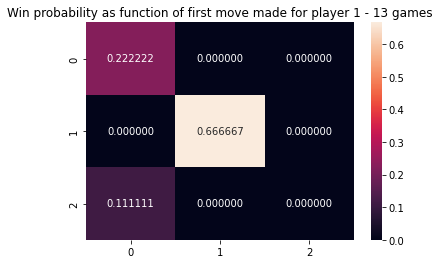

In [13]:
generate_heatmap(df, player=1)